# spaCy and networkx その３

名前列挙に対する動的な重みづけに対応：[人名列挙の探索](finding_group.ipynb)

Date: 2023/12/26

Reference: https://youtu.be/fAHkJ_Dhr50

Free book "Johann Sebastian Bach: His Life, Art, and Work" from Project Gutenberg: https://www.gutenberg.org/ebooks/35041

In [1]:
import spacy
import re

nlp = spacy.load('en_core_web_trf')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


In [2]:
with open('../data/pg35041_.txt') as f:
    text_ = f.read()

text_ = re.sub(r'_*\(\d+\)|_', '', text_)
text_ = re.sub(r'\d+\.\s', '\n', text_)
text_ = re.sub(r'\s{6}', '', text_)
text = re.sub(r'\n{2}', '|', text_)

paragraphes = text.replace('\n$', ' ').replace('\n', ' ').split('|')
paragraphes[100:105]

['Carl Philipp Emmanuel, in the preface to his father\'s Vierstimmige Choralgesänge ("Four-part Hymn-tunes"), which he edited, says that the world was accustomed to look for nothing but masterpieces from Bach. Some reviewers thought this praise exaggerated.  But if the term "masterpiece" is restricted to works written during the years of Bach\'s maturity it is nothing less than the truth.  Others have produced masterpieces in various forms which may be placed honourably by the side of his.  For instance, certain Allemandes, Courantes, etc., by Handel and others are not less beautiful, though less richly wrought, than Bach\'s. But in Fugue, Counterpoint, and Canon he stands alone, in a grandeur so isolated that all around him seems desert and void.  No one ever wrote Fugues to compare with his; indeed, persons unacquainted with them cannot imagine what a Fugue is and ought to be.  The ordinary Fugue follows a rule of thumb development.  It takes a theme, puts another beside it, passes t

In [3]:
CLEANED_NAMES =['Anna Magdalena',
 'Bach',
 'Beethoven',
 'Böhm',
 'Bruhns',
 'Buxtehude',
 'Carl Philipp',
 'Carl Philipp Emmanuel',
 'Caspar Kerl',
 'Charles III',
 'Charles of Sicily',
 'Christopher Weigel',
 'Count Kaiserling',
 'Couperin',
 'Duke Christian of Weissenfels',
 'Duke Ernst',
 'Elias Gottlieb Haussmann',
 'Emmanuel Bach',
 'Forkel',
 'Fischer',
 'Frederick II',
 'Frescobaldi',
 'Friedemann',
 'Friedrich Müller',
 'Fritz',
 'Fritz Volbach',
 'Froberger',
 'Gottfried Baron van Swieten',
 'Görner',
 'Handel',
 'Hasse',
 'Haussmann',
 'Haydn',
 'Hence Bach',
 'Herein Bach',
 'Hoffmeister',
 'J. C. Gottsched',
 'Johann Ambrosius',
 'Johann Abraham Birnbaum',
 'Johann Adam Reinken',
 'Johann Ambrosius Bach',
 'Johann Bernhard Bach',
 'Johann Christian Hoffmann',
 'Johann Christoph',
 'Johann Christoph Bach',
 "Johann Christoph Friedrich's",
 'Johann G. Schübler',
 'Johann Gottlieb Görner',
 'Johann Caspar Kerl',               
 'Johann Heinrich Ernesti',
 'Johann Matthias Gesner',
 'Johann Michael Bach',
 'Johann Sebastian',
 'Johann Sebastian Bach',
 'Kühnel',
 'Kerl',
 'Maria Amalia',
 'Marianne von Ziegler',
 'Messrs',
 'Mozart',
 'Müller',
 'Nicolas',
 'Pachelbel',
 'Paul Wagner',
 'Peters',
 'Philipp Telemann',
 'Regine Susanna',
 'Reinhard Keiser',
 'Sebastian Bach',
 'Veit Bach',
 'Vereinigte Zwietracht',
 'Vierstimmige Choralgesänge',
 'Vivaldi',
 'Vom Himmel',
 'Wahre Grundsätze',
 'Wasserflüssen Babylon',
 'Wilhelm Friedemann']

REPLACE = {'Bach': 'Johann Sebastian Bach',
           'Johann Sebastian': 'Johann Sebastian Bach',
           'Sebastian Bach': 'Johann Sebastian Bach',
           'Carl Philipp': 'Carl Philipp Emanuel Bach',
           'Carl Philipp Emanuel': 'Carl Philipp Emanuel Bach',
           'Carl Philipp Emmanuel': 'Carl Philipp Emanuel Bach', 
           'Emmanuel Bach': 'Carl Philipp Emanuel Bach',            
           'Wilhelm Friedemann': 'Wilhelm Friedemann Bach',
           'Friedemann': 'Wilhelm Friedemann Bach',
           'Johann Christoph': 'Johann Christoph Bach',
           'Anna Magdalena': 'Anna Magdalena Bach',
           'Regine Susanna': 'Regine Susanna Bach',
           'Johann Ambrosius': 'Johann Ambrosius Bach'
          }

def align_names(namelist):
    namelist_ = [name.replace("'s", "") for name in namelist]
    return [REPLACE[name] if name in REPLACE else name for name in namelist_]

# Test
align_names(['Bach', 'Carl Philipp'])

['Johann Sebastian Bach', 'Carl Philipp Emanuel Bach']

In [4]:
# グループの先頭のTokenを探索
def findHead(token, head):
    if token.dep_ == 'conj':
        findHead(token.head, head)
    else:
        head.append(token)

# PROPNで列挙されるTokenを探索
def findGroup(token, groups):
    for t in token.children:
        if (t.pos_ == 'PROPN' and t.dep_ == 'conj'):
            #print(t.head.text, t.text)
            head = []
            findHead(t, head)
            #print(head)
            head_ = head[0]
            if not head_ in groups:
                groups[head_] = [head_]
            groups[head_].append(t)
        try:
            first = next(t.children)
            findGroup(t, groups)
        except StopIteration:
            pass

# フルネームを得るため、compoundの関係で結ばれるPROPNを全て接続
def fullname(token, text=False):
    name = []
    for t in token.children:
        if t.dep_ == 'compound':
            name.append(t)
    name.append(token)
    if text:
        return ' '.join([token.text for token in name])
    else:
        return name

# 文の中で名前の列挙を探索し列挙グループの配列と列挙グループに含まれない名前の配列を返す
def findPersonsInGroup(doc, all_names=False, cleaned_names=False):
    groups = []
    persons_ = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']
    if cleaned_names:
        persons_ = [name for name in persons_ if name in CLEANED_NAMES]
    persons_ = align_names(persons_)
    persons = set(persons_)
    for token in doc:
        if token.dep_ == 'ROOT':
            root = token
            groups_ = {}
            findGroup(root, groups_)
            for group in groups_.values():
                fullname_list = [fullname(token, text=True) for token in group]
                fullname_list = align_names(fullname_list)
                # PERSONのみ抽出
                persons_fullname_list = [name for name in fullname_list if name in persons]
                #print(persons_fullname_list)
                if len(persons_fullname_list) > 0:
                    groups.append(set(persons_fullname_list))
    if not all_names:
        for group in groups:
            for name in group:
                persons.remove(name)
    return (groups, persons)

In [5]:
import itertools

def isPairInGroup(node_a, node_b, groups):
    is_group_member = False
    for group in groups:
        if node_a in group and node_b in group:
            is_group_member = True
            break
    if is_group_member:
        weight = 2/len(group)  # グループ内メンバ間のweightは反比例の関係
    else:
        weight = 1  # グループ外では常にweightを1とする
    return (is_group_member, weight)

network = []
for doc in nlp.pipe(paragraphes):
    for cleaned_names in (True, ):  # CLEANED_NAMESに人名漏れないかチェックしたいときには (True, False)にする
        groups, persons = findPersonsInGroup(doc, all_names=True, cleaned_names=cleaned_names)
        for node_pair in itertools.combinations(persons, r=2):
            weight = isPairInGroup(node_pair[0], node_pair[1], groups)
            network.append([node_pair[0], node_pair[1], weight[1]])

In [6]:
import pandas as pd
df = pd.DataFrame(network, columns=['source', 'target', 'weight'])
df.sample(10)

,source,target,weight
106,Johann Sebastian Bach,Couperin,1.000000
20,Fischer,Bruhns,0.285714
6,Johann Ambrosius Bach,Johann Christoph Bach,1.000000
2,Johann Christoph Bach,Carl Philipp Emanuel Bach,1.000000
10,Froberger,Böhm,0.285714
85,Anna Magdalena Bach,Johann Christoph Friedrich,1.000000
60,Johann Sebastian Bach,Maria Amalia,1.000000
67,Johann Abraham Birnbaum,Johann Christian Hoffmann,1.000000
176,Handel,Hasse,0.666667
122,Frescobaldi,Bruhns,0.250000


In [7]:
relationships_df = df.groupby(['source', 'target'], sort=False, as_index=False).sum()
relationships_df.sample(10)

,source,target,weight
23,Fischer,Johann Christoph Bach,1.000000
1,Johann Christoph Bach,Johann Michael Bach,1.000000
21,Fischer,Pachelbel,0.535714
86,Regine Susanna Bach,Johann Sebastian Bach,1.000000
42,Pachelbel,Buxtehude,0.535714
111,Böhm,Kerl,0.250000
62,Marianne von Ziegler,Johann Christian Hoffmann,0.666667
45,Handel,Johann Sebastian Bach,3.000000
32,Johann Caspar Kerl,Pachelbel,0.285714
47,Wilhelm Friedemann Bach,Johann Sebastian Bach,9.000000


In [8]:
import networkx as nx
G = nx.from_pandas_edgelist(relationships_df,
                            source = 'source',
                            target = 'target',
                            edge_attr = 'weight',
                            create_using=nx.Graph())

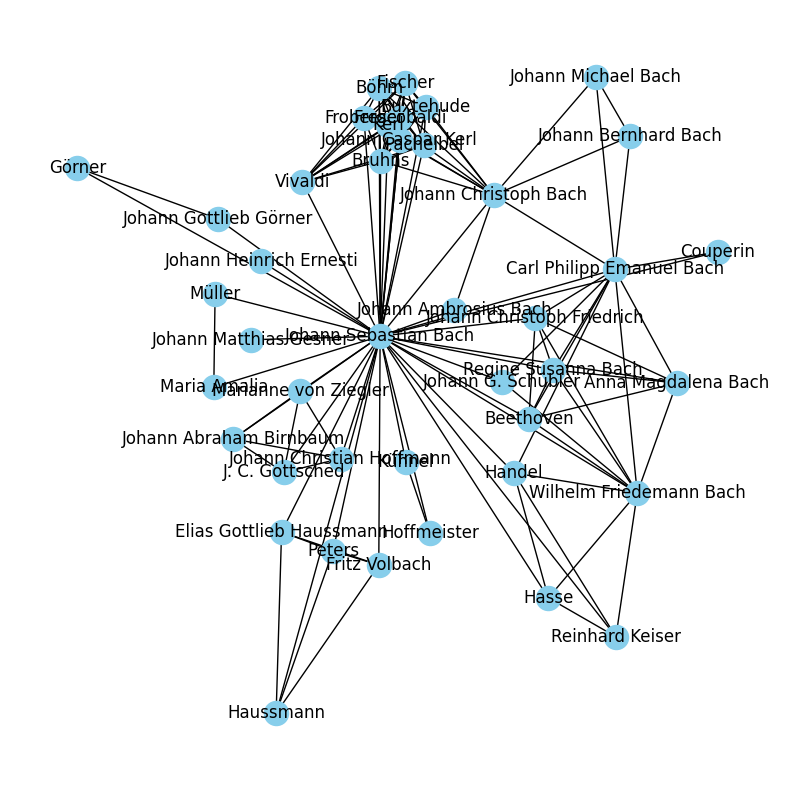

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, ax=ax, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

In [10]:
from pyvis.network import Network
net = Network(notebook=True, width='1000px', height='700px', bgcolor='#222222', font_color='white', cdn_resources='in_line')

node_degree = dict(G.degree)
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G, edge_scaling=True, show_edge_weights=True)
net.show('bach.html')

bach.html


<Axes: >

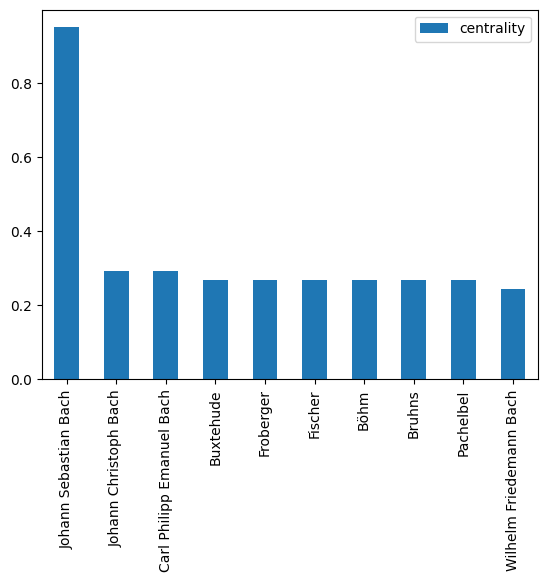

In [11]:
degree_dict = nx.degree_centrality(G)
degree_dict
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
degree_df.sort_values('centrality', ascending=False)[:10].plot(kind='bar')

<Axes: >

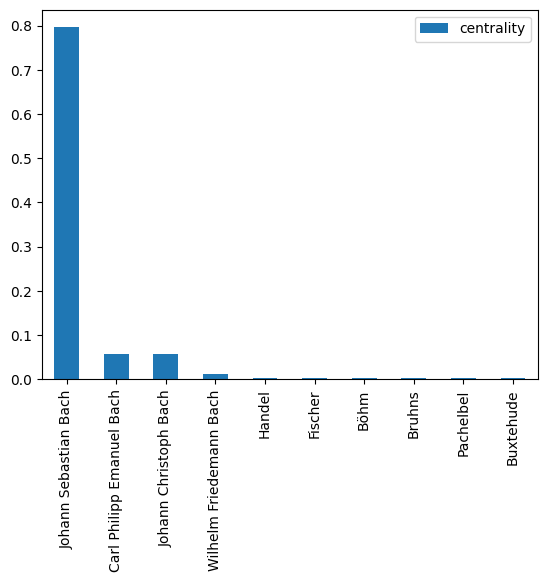

In [12]:
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
betweenness_df.sort_values('centrality', ascending=False)[:10].plot(kind='bar')

<Axes: >

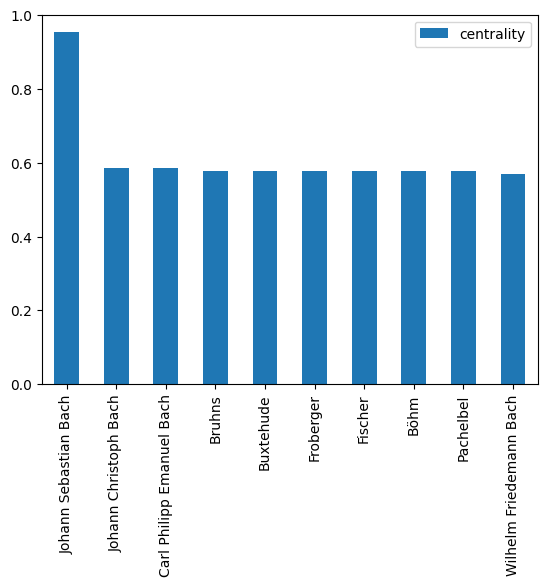

In [13]:
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
closeness_df.sort_values('centrality', ascending=False)[:10].plot(kind='bar')

In [14]:
from community import community_louvain

communities = community_louvain.best_partition(G)

nx.set_node_attributes(G, communities, 'group')

com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.show_buttons(filter_=['physics'])
com_net.show("bach_communities.html")

bach_communities.html


In [15]:
nodes = []
for node in G.nodes.data(data=True):
    nodes.append({'key': node[0], 'attributes': {'value': node[1]['size']}})
nodes

[{'key': 'Johann Christoph Bach', 'attributes': {'value': 12}},
 {'key': 'Johann Bernhard Bach', 'attributes': {'value': 3}},
 {'key': 'Johann Michael Bach', 'attributes': {'value': 3}},
 {'key': 'Carl Philipp Emanuel Bach', 'attributes': {'value': 12}},
 {'key': 'Johann Ambrosius Bach', 'attributes': {'value': 2}},
 {'key': 'Johann Sebastian Bach', 'attributes': {'value': 39}},
 {'key': 'Froberger', 'attributes': {'value': 11}},
 {'key': 'Fischer', 'attributes': {'value': 11}},
 {'key': 'Böhm', 'attributes': {'value': 11}},
 {'key': 'Johann Caspar Kerl', 'attributes': {'value': 8}},
 {'key': 'Bruhns', 'attributes': {'value': 11}},
 {'key': 'Pachelbel', 'attributes': {'value': 11}},
 {'key': 'Buxtehude', 'attributes': {'value': 11}},
 {'key': 'Handel', 'attributes': {'value': 5}},
 {'key': 'Couperin', 'attributes': {'value': 2}},
 {'key': 'Wilhelm Friedemann Bach', 'attributes': {'value': 10}},
 {'key': 'Görner', 'attributes': {'value': 2}},
 {'key': 'Johann Gottlieb Görner', 'attribut

In [16]:
edges = []
for edge in G.edges.data(data=True):
    edges.append({'key': f'{edge[0]}:{edge[1]}','source': edge[0], 'target': edge[1], 'attributes': {'value': edge[2]['value']}})
edges[:10]

[{'key': 'Johann Christoph Bach:Johann Bernhard Bach',
  'source': 'Johann Christoph Bach',
  'target': 'Johann Bernhard Bach',
  'attributes': {'value': 1.0}},
 {'key': 'Johann Christoph Bach:Johann Michael Bach',
  'source': 'Johann Christoph Bach',
  'target': 'Johann Michael Bach',
  'attributes': {'value': 1.0}},
 {'key': 'Johann Christoph Bach:Carl Philipp Emanuel Bach',
  'source': 'Johann Christoph Bach',
  'target': 'Carl Philipp Emanuel Bach',
  'attributes': {'value': 1.0}},
 {'key': 'Johann Christoph Bach:Johann Ambrosius Bach',
  'source': 'Johann Christoph Bach',
  'target': 'Johann Ambrosius Bach',
  'attributes': {'value': 1.0}},
 {'key': 'Johann Christoph Bach:Johann Sebastian Bach',
  'source': 'Johann Christoph Bach',
  'target': 'Johann Sebastian Bach',
  'attributes': {'value': 1.0}},
 {'key': 'Johann Christoph Bach:Froberger',
  'source': 'Johann Christoph Bach',
  'target': 'Froberger',
  'attributes': {'value': 1.0}},
 {'key': 'Johann Christoph Bach:Fischer',
  

In [17]:
with open('../docs/graph_data.js', 'w', encoding='utf-8') as f:
    f.write(f'var nodes = {nodes};\n\nvar edges = {edges};')